# useful benchmarks directories
test_all_spec_benchmarks20250920T204859Z

## just one run

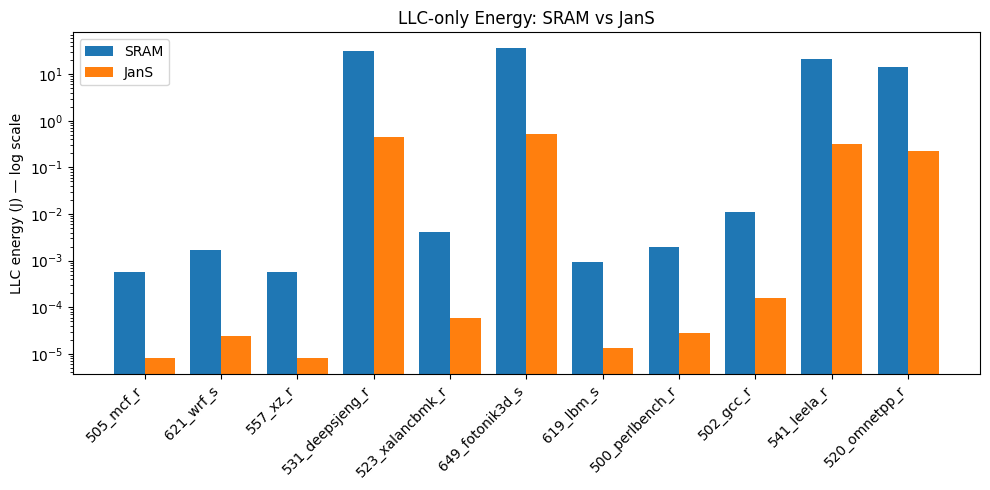

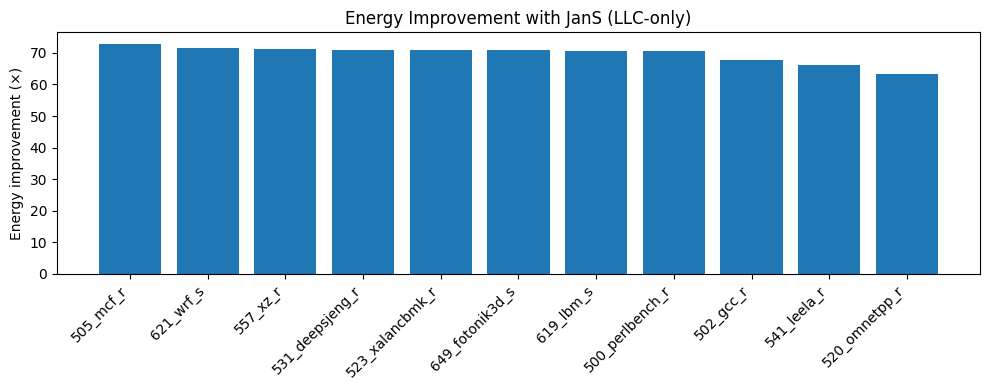

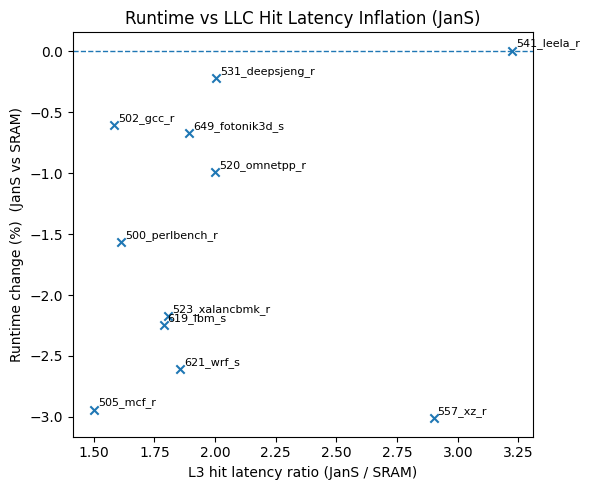

Benchmarks: 11
Median energy improvement (×): 70.80461464168437
Median runtime delta (%): -1.5679442508710806
Median hit-latency ratio: 1.8556488513345428


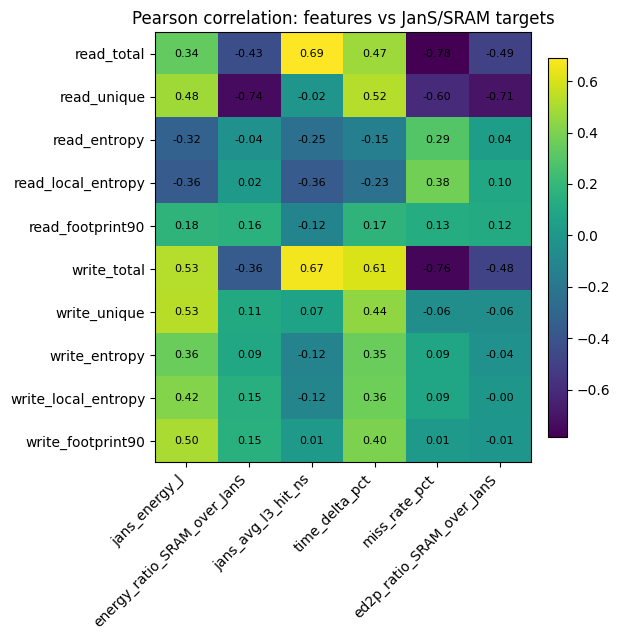

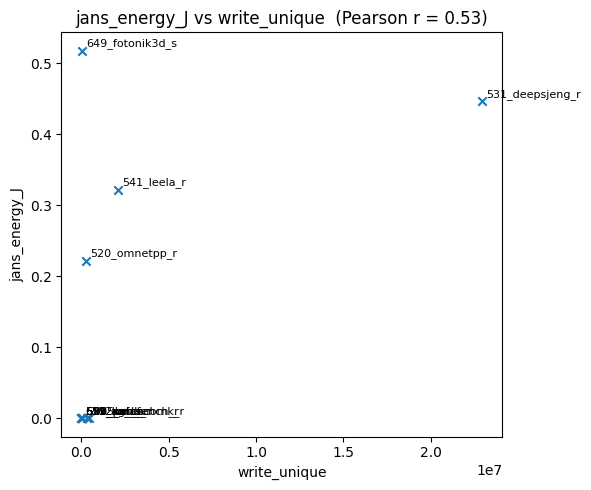

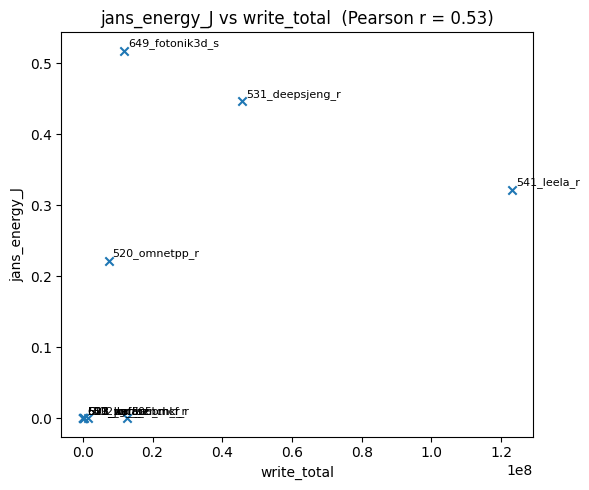

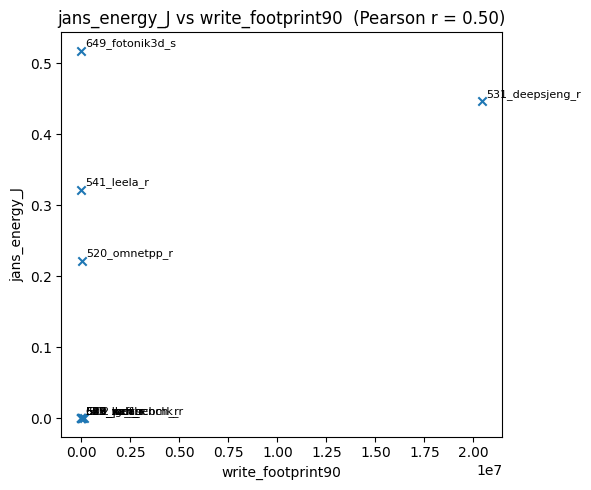

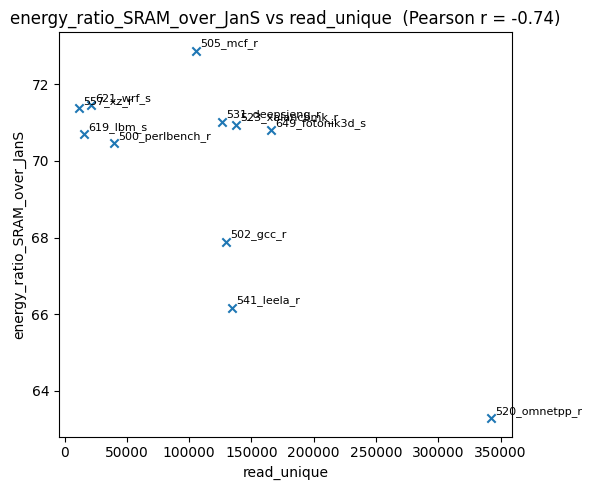

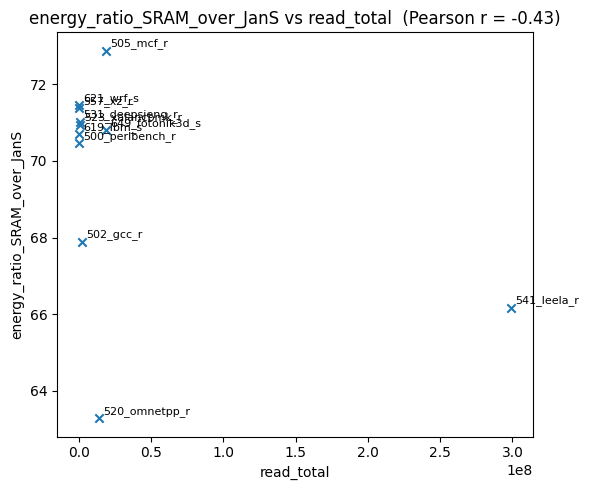

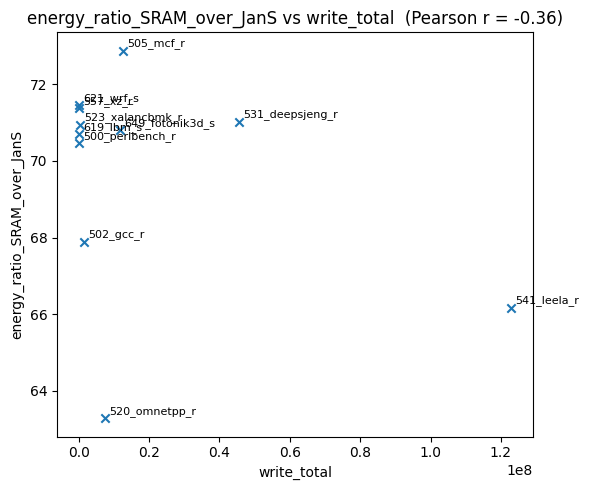

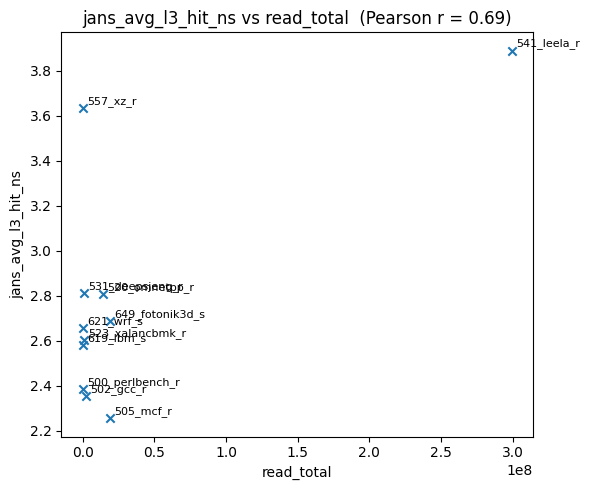

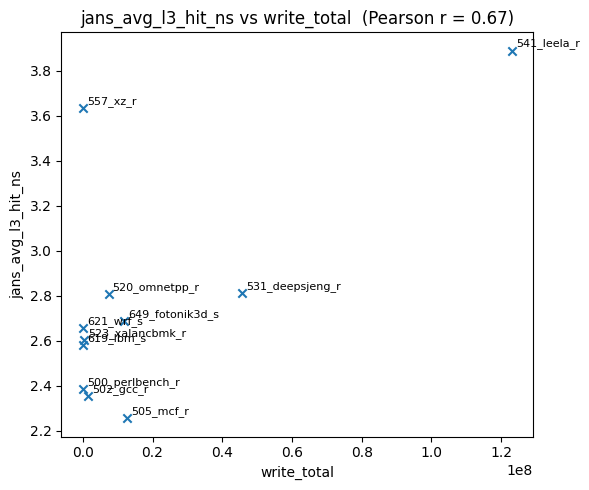

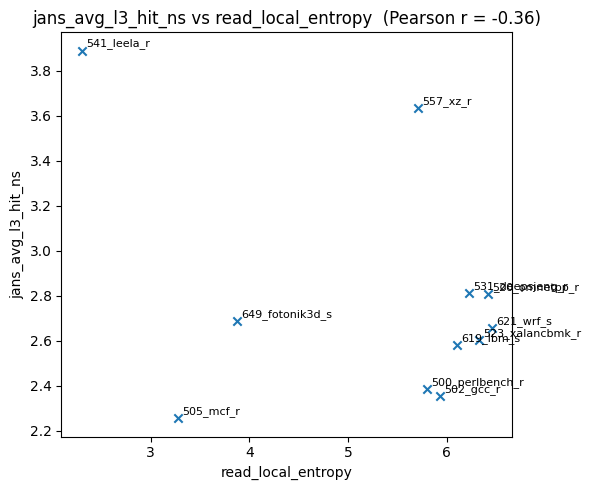

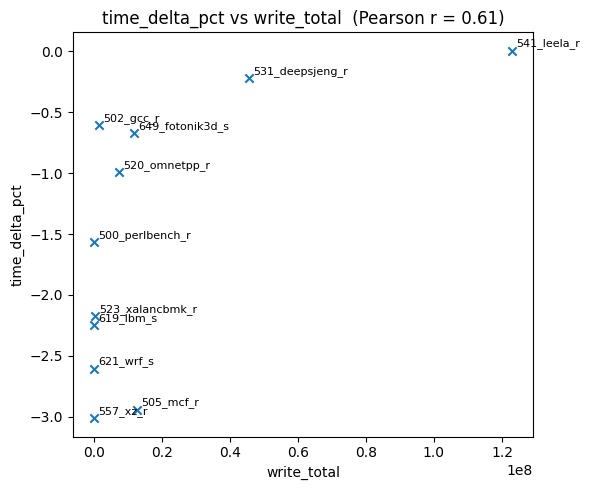

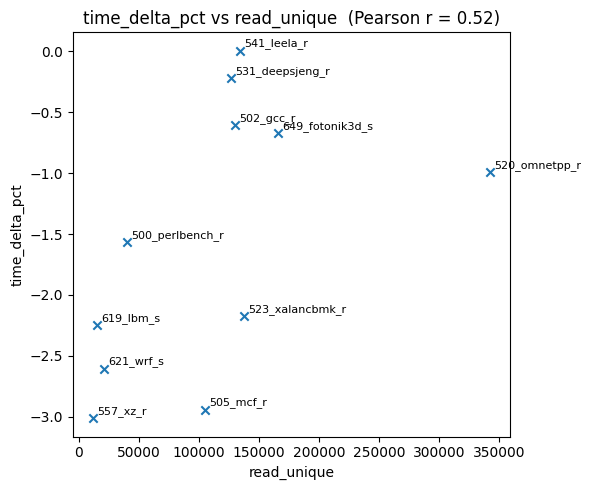

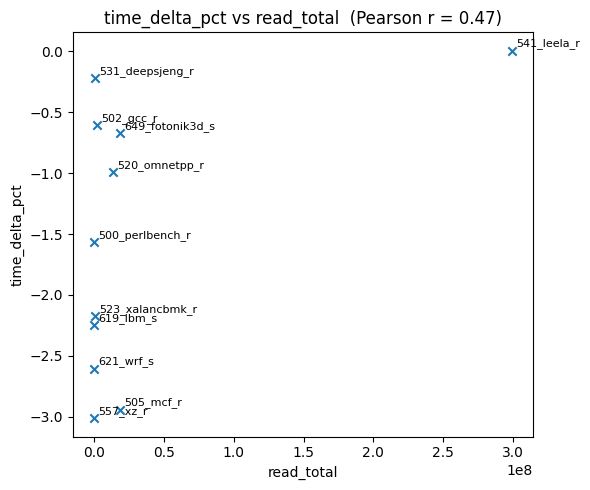

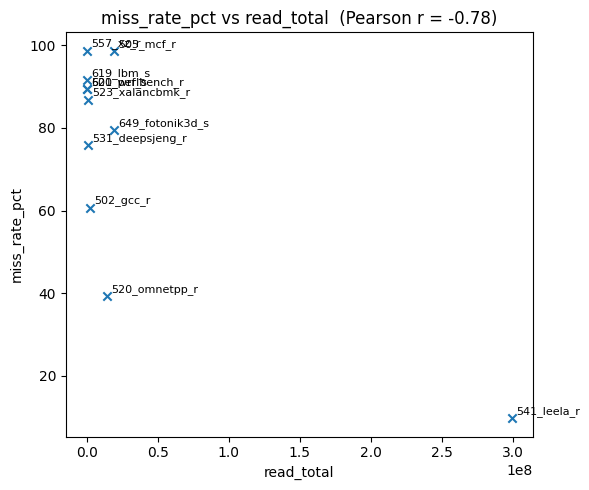

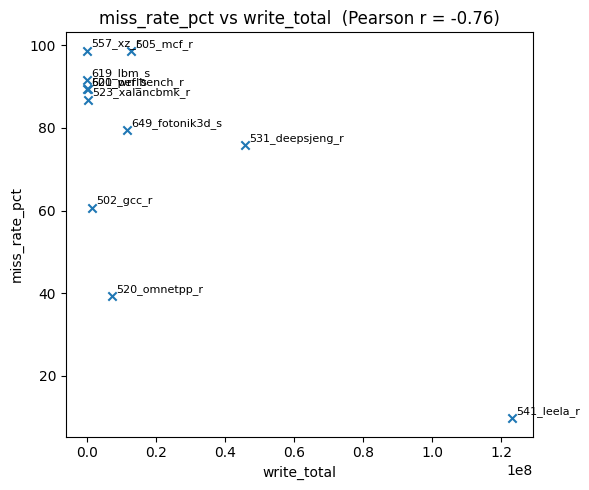

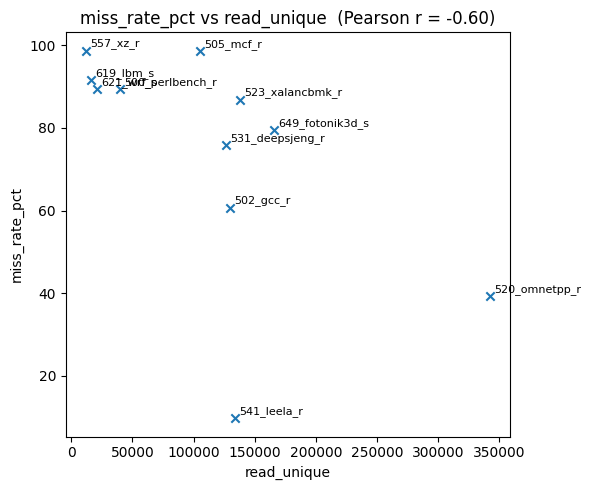

Merged benches: 11
Targets summary (median):
  jans_energy_J: 5.8e-05
  energy_ratio_SRAM_over_JanS: 70.80461464168437
  jans_avg_l3_hit_ns: 2.65553
  time_delta_pct: -1.5679442508710806
  miss_rate_pct: 86.81
  ed2p_ratio_SRAM_over_JanS: 71.94726836769905


In [49]:
import os, glob, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RUN_ID  = "test_all_spec_benchmarks20250920T204859Z"
RUN_ID = "test_all_spec_benchmarks_iso8m_20250921T153104Z"
RUN_DIR = f"/home/skataoka26/COSC_498/miniMXE/results/{RUN_ID}"
FEATURES_CSV = "/home/skataoka26/COSC_498/miniMXE/results_trace/features_20250921T040119Z.csv"

# ---- Load energy_bounds.csv from all output_* dirs ----
energy_files = sorted(glob.glob(os.path.join(RUN_DIR, "output_*", "energy_bounds.csv")))
if not energy_files:
    raise SystemExit(f"No energy_bounds.csv found under {RUN_DIR}")

dfE = pd.concat([pd.read_csv(f) for f in energy_files], ignore_index=True)

# Normalize types
for col in ["time_s", "energy_exact_J", "ed2p_exact_J_s2"]:
    dfE[col] = pd.to_numeric(dfE[col], errors="coerce")

# Pivot to get columns per config (SRAM, JanS) for visualization section
E_piv = dfE.pivot_table(index="benchmark", columns="config",
                        values=["time_s", "energy_exact_J", "ed2p_exact_J_s2"],
                        aggfunc="first")

def pick_epiv(col, cfg):
    return E_piv[(col, cfg)] if (col, cfg) in E_piv.columns else np.nan

benchmarks = E_piv.index.tolist()
sram_E    = pick_epiv("energy_exact_J", "SRAM")
jans_E    = pick_epiv("energy_exact_J", "JanS")
sram_T    = pick_epiv("time_s", "SRAM")
jans_T    = pick_epiv("time_s", "JanS")
sram_ED2P = pick_epiv("ed2p_exact_J_s2", "SRAM")
jans_ED2P = pick_epiv("ed2p_exact_J_s2", "JanS")

summary_files = sorted(glob.glob(os.path.join(RUN_DIR, "output_*", "summary.csv")))
if not summary_files:
    raise SystemExit(f"[ERR] No summary.csv found under {RUN_DIR}")

dfS = pd.concat([pd.read_csv(f) for f in summary_files], ignore_index=True)

# Ensure s
if "avg_l3_hit_ns" in dfS.columns:
    dfS["avg_l3_hit_ns"] = pd.to_numeric(dfS["avg_l3_hit_ns"], errors="coerce")
if "l3_miss_rate_pct" in dfS.columns:
    dfS["l3_miss_rate_pct"] = pd.to_numeric(dfS["l3_miss_rate_pct"], errors="coerce")

S_piv = dfS.pivot_table(index="benchmark", columns="config",
                        values="avg_l3_hit_ns", aggfunc="first")

sram_hit_ns = S_piv["SRAM"] if "SRAM" in S_piv.columns else pd.Series(index=benchmarks, dtype=float)
jans_hit_ns = S_piv["JanS"] if "JanS" in S_piv.columns else pd.Series(index=benchmarks, dtype=float)

df = pd.DataFrame({
    "benchmark": benchmarks,
    "sram_energy_J": sram_E.values,
    "jans_energy_J": jans_E.values,
    "sram_time_s":   sram_T.values,
    "jans_time_s":   jans_T.values,
    "sram_avg_l3_hit_ns": sram_hit_ns.reindex(benchmarks).values,
    "jans_avg_l3_hit_ns": jans_hit_ns.reindex(benchmarks).values,
    "sram_ed2p": sram_ED2P.values,
    "jans_ed2p": jans_ED2P.values,
}).dropna(subset=["sram_energy_J","jans_energy_J","sram_time_s","jans_time_s"])

df["energy_ratio_SRAM_over_JanS"] = df["sram_energy_J"] / df["jans_energy_J"]
df["time_delta_pct"] = 100.0 * (df["jans_time_s"] - df["sram_time_s"]) / df["sram_time_s"]
df["hit_ns_ratio_JanS_over_SRAM"] = df["jans_avg_l3_hit_ns"] / df["sram_avg_l3_hit_ns"]
df["ed2p_ratio_SRAM_over_JanS"] = df["sram_ed2p"] / df["jans_ed2p"]

# Order by energy improvement
df_sorted = df.sort_values("energy_ratio_SRAM_over_JanS", ascending=False).reset_index(drop=True)

plt.figure(figsize=(10,5))
x = np.arange(len(df_sorted))
width = 0.4
plt.bar(x - width/2, df_sorted["sram_energy_J"], width, label="SRAM")
plt.bar(x + width/2, df_sorted["jans_energy_J"], width, label="JanS")
plt.yscale("log")
plt.xticks(x, df_sorted["benchmark"], rotation=45, ha="right")
plt.ylabel("LLC energy (J) — log scale")
plt.title("LLC-only Energy: SRAM vs JanS")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
x = np.arange(len(df_sorted))
plt.bar(x, df_sorted["energy_ratio_SRAM_over_JanS"])
plt.xticks(x, df_sorted["benchmark"], rotation=45, ha="right")
plt.ylabel("Energy improvement (×)")
plt.title("Energy Improvement with JanS (LLC-only)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5))
xr = df["hit_ns_ratio_JanS_over_SRAM"].values
yr = df["time_delta_pct"].values
plt.scatter(xr, yr, marker="x")
for i, row in df.iterrows():
    if not (np.isnan(row["hit_ns_ratio_JanS_over_SRAM"]) or np.isnan(row["time_delta_pct"])):
        plt.annotate(row["benchmark"], (row["hit_ns_ratio_JanS_over_SRAM"], row["time_delta_pct"]),
                     fontsize=8, xytext=(3,3), textcoords="offset points")
plt.axhline(0, linestyle="--", linewidth=1)
plt.xlabel("L3 hit latency ratio (JanS / SRAM)")
plt.ylabel("Runtime change (%)  (JanS vs SRAM)")
plt.title("Runtime vs LLC Hit Latency Inflation (JanS)")
plt.tight_layout()
plt.show()

print("Benchmarks:", len(df_sorted))
print("Median energy improvement (×):", df["energy_ratio_SRAM_over_JanS"].median())
print("Median runtime delta (%):", df["time_delta_pct"].median())
print("Median hit-latency ratio:", df["hit_ns_ratio_JanS_over_SRAM"].median())


# DONT LOOK AT THIS
def to_float(x):
    try:
        return float(str(x).strip())
    except Exception:
        return np.nan

def bench_key_from_features(name):
    # "500.perlbench_r" -> "500_perlbench_r"
    return str(name).replace(".", "_")

def bench_key_from_energy(name):
    # already like "500_perlbench_r"
    return str(name)

# Load features
feat = pd.read_csv(FEATURES_CSV)
feat["bench"] = feat["name"].map(bench_key_from_features)

feature_cols = [
    "read_total","read_unique","read_entropy","read_local_entropy","read_footprint90",
    "write_total","write_unique","write_entropy","write_local_entropy","write_footprint90",
]
for c in feature_cols:
    feat[c] = pd.to_numeric(feat[c], errors="coerce")

feat_small = feat[["bench"] + feature_cols].drop_duplicates()

dfE["bench"] = dfE["benchmark"].map(bench_key_from_energy)

# Pivot: one row per bench, columns per config (SRAM / JanS)
E = dfE.pivot_table(index="bench", columns="config",
                    values=["time_s","energy_exact_J","ed2p_exact_J_s2"], aggfunc="first")

dfS["bench"] = dfS["benchmark"].map(bench_key_from_energy)

S_hit = dfS.pivot_table(index="bench", columns="config", values="avg_l3_hit_ns", aggfunc="first")
S_miss = dfS.pivot_table(index="bench", columns="config", values="l3_miss_rate_pct", aggfunc="first")

def pick(frame, tup):
    return frame[tup] if tup in frame.columns else pd.Series(dtype=float)

bench_index = sorted(set(E.index) | set(S_hit.index) | set(S_miss.index) | set(feat_small["bench"]))
df = pd.DataFrame({"bench": bench_index}).set_index("bench")

df["sram_energy_J"] = pick(E, ("energy_exact_J","SRAM")).reindex(bench_index)
df["jans_energy_J"] = pick(E, ("energy_exact_J","JanS")).reindex(bench_index)
df["sram_time_s"]   = pick(E, ("time_s","SRAM")).reindex(bench_index)
df["jans_time_s"]   = pick(E, ("time_s","JanS")).reindex(bench_index)
df["sram_ed2p"]     = pick(E, ("ed2p_exact_J_s2","SRAM")).reindex(bench_index)
df["jans_ed2p"]     = pick(E, ("ed2p_exact_J_s2","JanS")).reindex(bench_index)

df["sram_avg_l3_hit_ns"] = S_hit.get("SRAM", pd.Series(dtype=float)).reindex(bench_index)
df["jans_avg_l3_hit_ns"] = S_hit.get("JanS", pd.Series(dtype=float)).reindex(bench_index)

miss_SRAM = S_miss.get("SRAM", pd.Series(dtype=float)).reindex(bench_index)
miss_JanS = S_miss.get("JanS", pd.Series(dtype=float)).reindex(bench_index)
df["miss_rate_pct"] = miss_JanS.fillna(miss_SRAM)
df["energy_ratio_SRAM_over_JanS"] = df["sram_energy_J"] / df["jans_energy_J"]
df["ed2p_ratio_SRAM_over_JanS"]   = df["sram_ed2p"] / df["jans_ed2p"]
df["time_delta_pct"] = 100.0 * (df["jans_time_s"] - df["sram_time_s"]) / df["sram_time_s"]
df["hit_ns_ratio_JanS_over_SRAM"] = df["jans_avg_l3_hit_ns"] / df["sram_avg_l3_hit_ns"]

df = df.merge(feat_small.set_index("bench"), left_index=True, right_index=True, how="inner").dropna()

targets = [
    "jans_energy_J",
    "energy_ratio_SRAM_over_JanS",
    "jans_avg_l3_hit_ns",
    "time_delta_pct",
    "miss_rate_pct",
    "ed2p_ratio_SRAM_over_JanS",
]
num_df = df[feature_cols + targets].apply(pd.to_numeric, errors="coerce").dropna()
corr = num_df[feature_cols + targets].corr(method="pearson")

C = corr.loc[feature_cols, targets].values
row_labels = feature_cols
col_labels = targets

plt.figure(figsize=(1.5 + 0.8*len(col_labels), 1.5 + 0.5*len(row_labels)))
im = plt.imshow(C, aspect="auto")  # default colormap, no explicit colors
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(np.arange(len(col_labels)), col_labels, rotation=45, ha="right")
plt.yticks(np.arange(len(row_labels)), row_labels)
plt.title("Pearson correlation: features vs JanS/SRAM targets")
for i in range(len(row_labels)):
    for j in range(len(col_labels)):
        val = C[i, j]
        if not (np.isnan(val) or np.isinf(val)):
            plt.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8)
plt.tight_layout()
plt.show()

def top_pairs_for(target, k=3):
    # absolute correlation between features and this target
    s = corr[target].loc[feature_cols].abs().sort_values(ascending=False)
    return [(fname, float(corr[target].loc[fname])) for fname in s.index[:k]]

for targ in ["jans_energy_J", "energy_ratio_SRAM_over_JanS",
             "jans_avg_l3_hit_ns", "time_delta_pct", "miss_rate_pct"]:
    pairs = top_pairs_for(targ, k=3)
    for fname, r in pairs:
        x = df[fname].values
        y = df[targ].values
        plt.figure(figsize=(6,5))
        plt.scatter(x, y, marker="x")
        for bn, xv, yv in zip(df.index, x, y):
            if not (np.isnan(xv) or np.isnan(yv)):
                plt.annotate(bn, (xv, yv), fontsize=8, xytext=(3,3), textcoords="offset points")
        plt.xlabel(fname)
        plt.ylabel(targ)
        plt.title(f"{targ} vs {fname}  (Pearson r = {r:.2f})")
        plt.tight_layout()
        plt.show()

print("Merged benches:", len(df))
print("Targets summary (median):")
for t in ["jans_energy_J","energy_ratio_SRAM_over_JanS","jans_avg_l3_hit_ns","time_delta_pct","miss_rate_pct","ed2p_ratio_SRAM_over_JanS"]:
    med = df[t].median()
    print(f"  {t}: {med}")

## multiple devices

[INFO] Loading data for 4 devices.
  - Loading 'JanS' from '/home/skataoka26/COSC_498/miniMXE/results/test_all_spec_benchmarks_iso8m_janS_custom_energy_20250922T051034Z'
  - Loading 'ChungS' from '/home/skataoka26/COSC_498/miniMXE/results/test_all_spec_benchmarks_iso8m_chungS_custom_energy_20250922T051023Z'
  - Loading 'UmekiS' from '/home/skataoka26/COSC_498/miniMXE/results/test_all_spec_benchmarks_iso8m_umekiS_custom_energy_20250922T051026Z'
  - Loading 'XueS' from '/home/skataoka26/COSC_498/miniMXE/results/test_all_spec_benchmarks_iso8m_xueS_custom_energy_20250922T051029Z'
[SAVED] /home/skataoka26/COSC_498/miniMXE/results/_viz_multi_cfg_final/three_panel_by_device.png


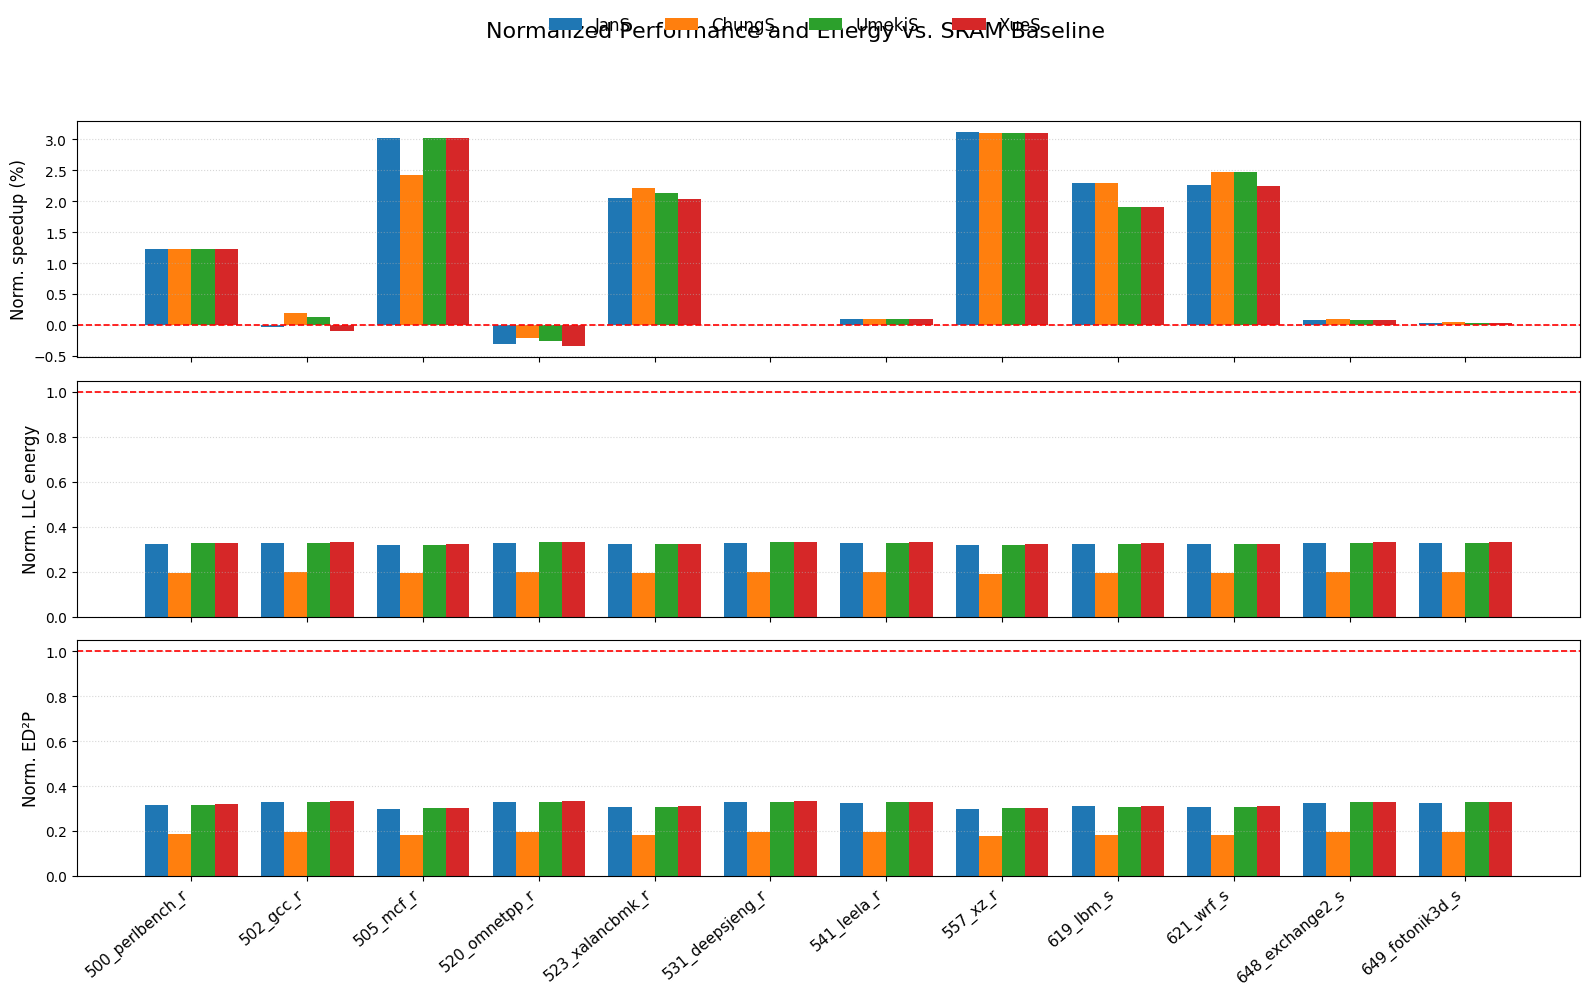


[INFO] Generating combined correlation heatmap...

--- Data sample for device: JanS ---
          benchmark  exe_time  LLC_energy
1   500_perlbench_r  0.000568    0.000643
5         502_gcc_r  0.003137    0.003562
9         505_mcf_r  0.000165    0.000187
13    520_omnetpp_r  0.034646    0.039152
17  523_xalancbmk_r  0.001172    0.001326

--- Data sample for device: ChungS ---
          benchmark  exe_time  LLC_energy
0   500_perlbench_r  0.000567    0.000385
4         502_gcc_r  0.003130    0.002136
8         505_mcf_r  0.000165    0.000112
12    520_omnetpp_r  0.034615    0.023466
16  523_xalancbmk_r  0.001171    0.000796

--- Data sample for device: UmekiS ---
          benchmark  exe_time  LLC_energy
2   500_perlbench_r  0.000567    0.000643
6         502_gcc_r  0.003132    0.003561
10        505_mcf_r  0.000165    0.000187
14    520_omnetpp_r  0.034630    0.039232
18  523_xalancbmk_r  0.001172    0.001329

--- Data sample for device: XueS ---
          benchmark  exe_time  LLC_en

/tmp/ipykernel_1875800/2692327742.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


[SAVED] /home/skataoka26/COSC_498/miniMXE/results/_viz_multi_cfg_final/corr_combined.png


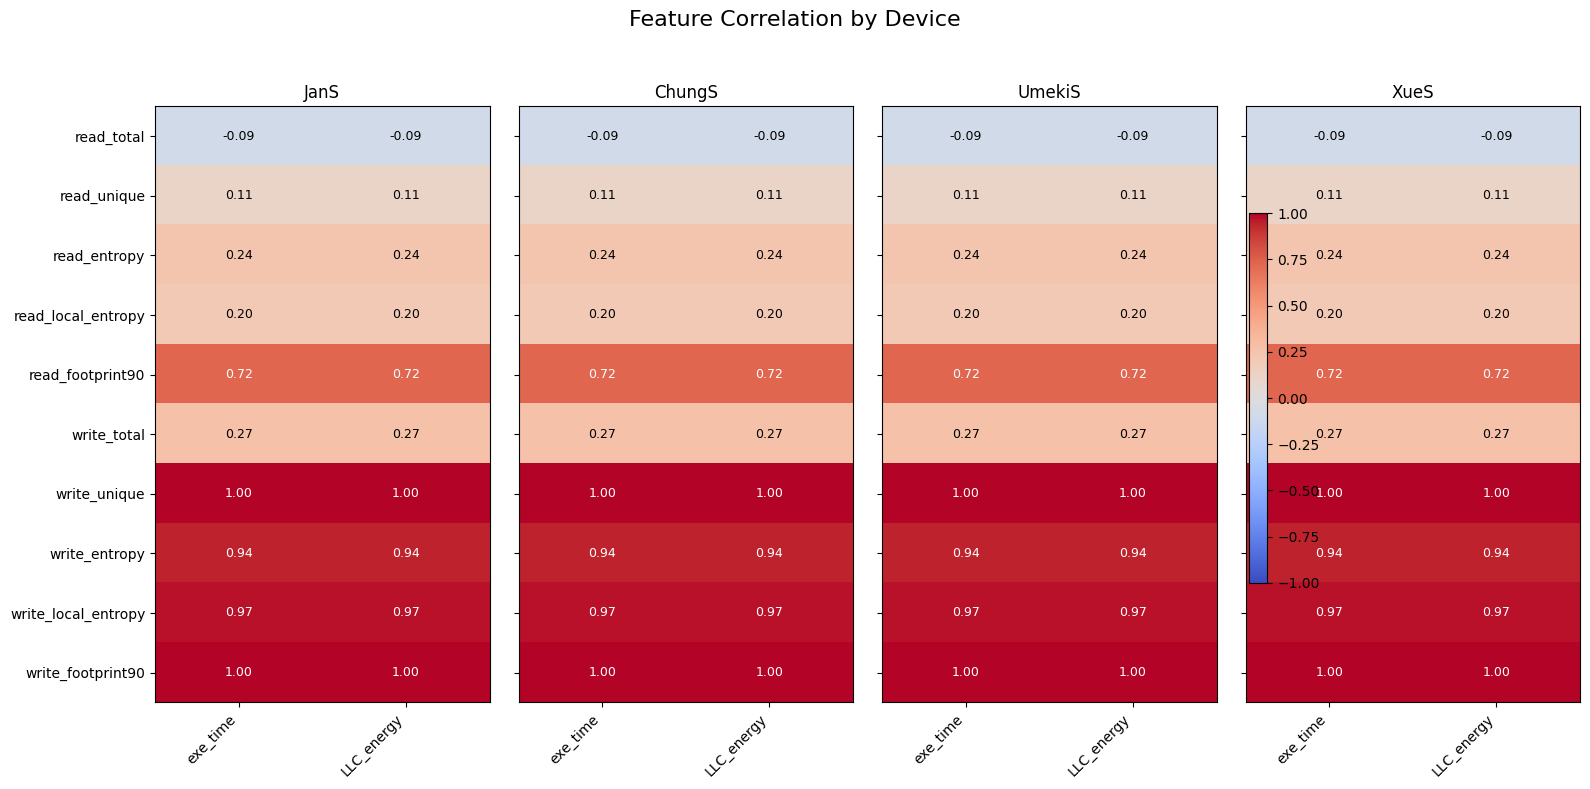

In [45]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

FEATURES_CSV = "/home/skataoka26/COSC_498/miniMXE/results_trace/features_20250921T040119Z.csv"

DEVICE_MAPPING = {
    "JanS":   "/home/skataoka26/COSC_498/miniMXE/results/test_all_spec_benchmarks_iso8m_janS_custom_energy_20250922T051034Z",
    "ChungS": "/home/skataoka26/COSC_498/miniMXE/results/test_all_spec_benchmarks_iso8m_chungS_custom_energy_20250922T051023Z",
    "UmekiS": "/home/skataoka26/COSC_498/miniMXE/results/test_all_spec_benchmarks_iso8m_umekiS_custom_energy_20250922T051026Z",
    "XueS":   "/home/skataoka26/COSC_498/miniMXE/results/test_all_spec_benchmarks_iso8m_xueS_custom_energy_20250922T051029Z",
}
DEVICES = list(DEVICE_MAPPING.keys())

BASELINE_CONFIG = "SRAM"

OUT_DIR = "/home/skataoka26/COSC_498/miniMXE/results/_viz_multi_cfg_final"
os.makedirs(OUT_DIR, exist_ok=True)

def read_all_energy_summaries(run_dirs):
    e_rows = []
    for rd in run_dirs:
        e_files = sorted(glob.glob(os.path.join(rd, "output_*", "energy_bounds.csv")))
        if not e_files:
            continue
        for f in e_files:
            try:
                df = pd.read_csv(f)
                df["run_dir"] = os.path.basename(rd)
                e_rows.append(df)
            except Exception as ex:
                print(f"[WARN] energy read failed {f}: {ex}")

    if not e_rows:
        return pd.DataFrame()

    dfE = pd.concat(e_rows, ignore_index=True)

    if 'benchmark' in dfE.columns:
        dfE['benchmark'] = dfE['benchmark'].str.replace('.', '_', regex=False)

    for c in ["time_s", "energy_exact_J", "ed2p_exact_J_s2"]:
        if c in dfE.columns:
            dfE[c] = pd.to_numeric(dfE[c], errors="coerce")
    return dfE

def tidy_unique_by_mean(dfE):
    keep = ["benchmark", "config", "device", "time_s", "energy_exact_J", "ed2p_exact_J_s2"]
    present = [c for c in keep if c in dfE.columns]
    g = dfE[present].groupby(["benchmark", "config", "device"], as_index=False).mean(numeric_only=True)
    return g

def plot_three_panel(speed_df, energy_df, ed2p_df, devices, title, outfile):
    fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)
    ax1, ax2, ax3 = axes
    x = np.arange(len(speed_df.index))
    width = max(0.8 / max(1, len(devices)), 0.1)

    # Plot Speedup
    for i, dev in enumerate(devices):
        vals = speed_df[dev].values.astype(float)
        ax1.bar(x + (i - (len(devices) - 1) / 2) * width, vals, width, label=dev)
    ax1.axhline(0, linestyle='--', linewidth=1.2, color='r')
    ax1.grid(True, axis='y', alpha=0.5, linestyle=':')
    ax1.set_ylabel("Norm. speedup (%)", fontsize=12)
    ax1.tick_params(axis='y', labelsize=10)

    # Plot Energy and ED2P
    # I dont know why I said ED2P honestly but lets be harsh on MRAM
    for ax, data, label in [(ax2, energy_df, "Norm. LLC energy"), (ax3, ed2p_df, "Norm. ED²P")]:
        for i, dev in enumerate(devices):
            vals = data[dev].values.astype(float)
            ax.bar(x + (i - (len(devices) - 1) / 2) * width, vals, width, label=dev)
        ax.axhline(1.0, linestyle='--', linewidth=1.2, color='r')
                #ax.set_yscale('log')
        #ax.set_ylim(0, 0.025)
        ax.grid(True, which='major', axis='y', alpha=0.5, linestyle=':')
        ax.grid(True, which='minor', axis='y', alpha=0.2, linestyle=':')
        ax.set_ylabel(label, fontsize=12)
        ax.tick_params(axis='y', labelsize=10)

    ax3.set_xticks(x)
    ax3.set_xticklabels(speed_df.index, rotation=40, ha="right", fontsize=11)
    
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=len(devices), fontsize=12, frameon=False)
    
    fig.suptitle(title, fontsize=16, y=0.98)
    fig.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig(outfile, dpi=200, bbox_inches='tight')
    print(f"[SAVED] {outfile}")
    plt.show()

def plot_combined_correlation_heatmaps(df_in, feature_cols, target_labels, devices, title, outfile):
    num_devices = len(devices)
    fig, axes = plt.subplots(1, num_devices, figsize=(4 * num_devices, 8), sharey=True)
    if num_devices == 1: # Ensure axes is always a list
        axes = [axes]

    print("\n[INFO] Generating combined correlation heatmap...")
    for ax, device in zip(axes, devices):
        # Filter the merged dataframe to get data ONLY for the current device (publication).
        device_df = df_in[df_in["device"] == device]
    
        print(f"\n--- Data sample for device: {device} ---")
        print(device_df[['benchmark'] + target_labels].head())        
        num_df = device_df[feature_cols + target_labels].apply(pd.to_numeric, errors="coerce").dropna()

        if num_df.empty or num_df.shape[0] < 2:
            ax.set_title(f"{device}\n(No Data)")
            ax.set_xticks([])
            continue
        corr = num_df.corr(method="pearson")
        C = corr.loc[feature_cols, target_labels].values
        
        im = ax.imshow(C, aspect="auto", cmap="coolwarm", vmin=-1, vmax=1)
        
        ax.set_xticks(np.arange(len(target_labels)))
        ax.set_xticklabels(target_labels, rotation=45, ha="right")
        ax.set_title(device, fontsize=12)

        # Add correlation values as text on the heatmap cells
        for i in range(len(feature_cols)):
            for j in range(len(target_labels)):
                val = C[i, j]
                if not np.isnan(val):
                    text_color = "white" if abs(val) > 0.6 else "black"
                    ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=9, color=text_color)
    
    axes[0].set_yticks(np.arange(len(feature_cols)))
    axes[0].set_yticklabels(feature_cols)

    fig.suptitle(title, fontsize=16)
    fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6, pad=0.02)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(outfile, dpi=200, bbox_inches='tight')
    print(f"[SAVED] {outfile}")
    plt.show()

def main():
    all_dfE_rows = []
    
    print(f"[INFO] Loading data for {len(DEVICES)} devices.")
    for device_name, dir_path in DEVICE_MAPPING.items():
        print(f"  - Loading '{device_name}' from '{dir_path}'")
        dfE_device = read_all_energy_summaries([dir_path])
        if not dfE_device.empty:
            dfE_device['device'] = device_name
            dfE_device.loc[dfE_device['config'] != BASELINE_CONFIG, 'config'] = device_name
            all_dfE_rows.append(dfE_device)

    if not all_dfE_rows:
        raise SystemExit("No data loaded. Check DEVICE_MAPPING paths.")
    
    dfE_full = pd.concat(all_dfE_rows, ignore_index=True)
    dfE_unique = tidy_unique_by_mean(dfE_full)

    speedup_data, energy_data, ed2p_data = {}, {}, {}
    all_benchmarks = set()

    for device in DEVICES:
        target_config = device
        df_dev = dfE_unique[(dfE_unique['device'] == device) & (dfE_unique['config'].isin([BASELINE_CONFIG, target_config]))]
        
        if df_dev.empty: continue

        pivoted = df_dev.pivot_table(index='benchmark', columns='config', values=['time_s', 'energy_exact_J', 'ed2p_exact_J_s2'])
        
        if (('time_s', BASELINE_CONFIG) not in pivoted.columns) or \
           (('time_s', target_config) not in pivoted.columns):
            continue
            
        pivoted.dropna(inplace=True)
        all_benchmarks.update(pivoted.index)

        t_base = pivoted[('time_s', BASELINE_CONFIG)]
        e_base = pivoted[('energy_exact_J', BASELINE_CONFIG)]
        d_base = pivoted[('ed2p_exact_J_s2', BASELINE_CONFIG)]
        
        t_cfg = pivoted[('time_s', target_config)]
        e_cfg = pivoted[('energy_exact_J', target_config)]
        d_cfg = pivoted[('ed2p_exact_J_s2', target_config)]

        speedup_data[device] = (t_base / t_cfg - 1.0) * 100.0
        energy_data[device] = e_cfg / e_base
        ed2p_data[device] = d_cfg / d_base

    if not speedup_data or not all_benchmarks:
        print("\n[ERROR] No devices had complete data for the bar plot. Skipping plot generation.")
    else:
        devices_to_plot = list(speedup_data.keys())
        all_benchmarks_sorted = sorted(list(all_benchmarks))
        speedup_df = pd.DataFrame(speedup_data).reindex(all_benchmarks_sorted)
        energy_df = pd.DataFrame(energy_data).reindex(all_benchmarks_sorted)
        ed2p_df = pd.DataFrame(ed2p_data).reindex(all_benchmarks_sorted)
        
        plot_title = "Normalized Performance and Energy vs. SRAM Baseline"
        outfile_bar = os.path.join(OUT_DIR, "three_panel_by_device.png")
        plot_three_panel(speedup_df, energy_df, ed2p_df, devices_to_plot, plot_title, outfile_bar)
    try:
        feat = pd.read_csv(FEATURES_CSV)
        feat["bench"] = feat["name"].str.replace('.', '_', regex=False)
    except FileNotFoundError:
        raise SystemExit(f"ERROR: Features file not found at: {FEATURES_CSV}")

    feature_cols = [c for c in [
        "read_total", "read_unique", "read_entropy", "read_local_entropy", "read_footprint90",
        "write_total", "write_unique", "write_entropy", "write_local_entropy", "write_footprint90"
    ] if c in feat.columns]
    
    df_corr_base = dfE_unique[dfE_unique['config'].isin(DEVICES)]
    merged_df = df_corr_base.merge(feat[["bench"] + feature_cols], left_on="benchmark", right_on="bench", how="inner")

    targets = ["time_s", "energy_exact_J"]
    target_labels = ["exe_time", "LLC_energy"]
    merged_df.rename(columns=dict(zip(targets, target_labels)), inplace=True)

    # FIX: Call the new combined plotting function.
    corr_title = "Feature Correlation by Device"
    outfile_corr = os.path.join(OUT_DIR, "corr_combined.png")
    plot_combined_correlation_heatmaps(merged_df, feature_cols, target_labels, DEVICES, corr_title, outfile_corr)

if __name__ == "__main__":
    main()